<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-数据说明与导入" data-toc-modified-id="1-数据说明与导入-1">1 数据说明与导入</a></span></li><li><span><a href="#2-数据初步探索" data-toc-modified-id="2-数据初步探索-2">2 数据初步探索</a></span><ul class="toc-item"><li><span><a href="#2.1-数据信息检查" data-toc-modified-id="2.1-数据信息检查-2.1">2.1 数据信息检查</a></span></li><li><span><a href="#2.2-数据清洗" data-toc-modified-id="2.2-数据清洗-2.2">2.2 数据清洗</a></span></li><li><span><a href="#2.3-数据可视化与分析" data-toc-modified-id="2.3-数据可视化与分析-2.3">2.3 数据可视化与分析</a></span><ul class="toc-item"><li><span><a href="#2.3.1-数据分布情况" data-toc-modified-id="2.3.1-数据分布情况-2.3.1">2.3.1 数据分布情况</a></span></li><li><span><a href="#2.3.2-结合违约情况查看数据分布" data-toc-modified-id="2.3.2-结合违约情况查看数据分布-2.3.2">2.3.2 结合违约情况查看数据分布</a></span></li><li><span><a href="#2.3.3-展示数据相关性" data-toc-modified-id="2.3.3-展示数据相关性-2.3.3">2.3.3 展示数据相关性</a></span></li></ul></li></ul></li><li><span><a href="#3-分类建模" data-toc-modified-id="3-分类建模-3">3 分类建模</a></span><ul class="toc-item"><li><span><a href="#3.1-KNN模型" data-toc-modified-id="3.1-KNN模型-3.1">3.1 KNN模型</a></span></li><li><span><a href="#3.2-决策树" data-toc-modified-id="3.2-决策树-3.2">3.2 决策树</a></span></li></ul></li><li><span><a href="#4-引入新评价指标" data-toc-modified-id="4-引入新评价指标-4">4 引入新评价指标</a></span></li><li><span><a href="#5-XGBoost" data-toc-modified-id="5-XGBoost-5">5 XGBoost</a></span><ul class="toc-item"></ul></li><li><span><a href="#6-结论" data-toc-modified-id="6-结论-6">6 结论</a></span></li></ul></div>

# 1 数据说明与导入

本案例使用的数据集为信用卡客户数据，具体的数据包括：每位客户案例的编号、客户的信用卡额度、性别、受教育程度、婚姻状况、年龄、在记录数据期间(2005年4-9月)每个月的还款情况、账单记录和支付记录，以及该客户在接下来的一个月中违约与否的记录。具体数据字段的表格信息记录如下:

| 列名 | 含义说明 | 数据类型 |
|:----|:----------:|----:|
| ID | 客户ID。 | int64 |
| LIMIT_BAL |	银行给予客户的信用额度，包括个人信用额度和客户的家庭信用额度。 | float64 |
| SEX |	客户的性别。男性记为1，女性记为2。 | int64 |
| EDUCATION |	客户的教育水平。研究生及以上记为1，大学记为2，高中记为3，其它记为0。 | int64 |
| MARRIAGE |	客户的婚姻状况。未婚记为2，已婚记为1，其它记为0。 | int64|
| AGE |	客户的年龄。 | int64 |
| PAY_1～PAY_6 |	这六个变量是2005年4月到9月每月的还款记录，取值为-1～9，代表累计逾期月数。 | int64 |
| BILL_AMT1～BILL_AMT6 |	这六个变量是2005年4月到9月每月的账单记录，即每月用信用卡消费记录。 | float64 |
| PAY_AMT1～PAY_AMT6 |	这六个变量是2005年4月到9月每月的支付记录，包括还账单金额和存入信用卡的金额。 | float64 |
| default.payment.next.month |	代表客户下个月是否违约，违约记为1，未违约则记为0。 | int64 |

我们首先导入整个案例过程中需要用到的部分包，主要包括Pandas、NumPy、可视化需要的Matplotlib、Seaborn以及一些机器学习包。

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.sans-serif']=['SimHei']   # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False     # 用来正常显示负号
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [2]:
df = pd.read_csv('data.csv')

# 2 数据初步探索

## 2.1 数据信息检查

首先，我们查看数据的前五行，检查数据读取情况。

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


下面我们通过`shape`查看数据的大小。

In [4]:
df.shape

(30000, 25)

接下来我们使用`info`检查数据的格式等基本信息。

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_1                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

可以看到，数据的大小为30000x25，且其中不存在任何的缺失值，非常完整。

我们还可以通过`describe`查看数据字段的基本统计信息，以获取数据的进一步信息。

In [6]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


一共有30000名信用卡持卡人的信息，这些持卡人信用卡平均额度`LIMIT_BAL`为167484，但是标准差达到了129747，信用卡最大额度达到100万，额度最小的仅有1000，跨度非常大；我们已知2代表女性，1代表男性，性别`SEX`的平均值在1.6以上，说明女性在该样本中的占比明显高于男性。同时我们也发现与描述不符的异常数据，教育程度`EDUCATION`的最大值和最小值均在给定的字段描述之外，婚姻状况`MARRIAGE`有标记为3的点，`PAY_1`到`PAY_6`的还款记录中出现了描述之外的-2，我们应逐一进行理解与清洗。

## 2.2 数据清洗

首先对教育程度的字段用`value_counts`进行查看：

In [7]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

教育程度`EDUCATION`标记为4，5，6的值都可以理解为"其他"，代表低于高中的学历。为了将学历按低到高进行排序，还需将标签为1和标签为3的数据互换标签。我们使用`replace`完成上述替换，`inplace`参数设置为`True`表示替换原数据。

In [8]:
df['EDUCATION'].replace([1,3,4,5,6],[3,1,0,0,0],inplace=True)
df['EDUCATION'].value_counts()

2    14030
3    10585
1     4917
0      468
Name: EDUCATION, dtype: int64

性别`SEX`的数据中，男性和女性标记为1和2，我们将其替换为0和1比较符合编程习惯。

In [9]:
df['SEX'].replace([1,2],[0,1],inplace=True)
df['SEX'].value_counts()

1    18112
0    11888
Name: SEX, dtype: int64

我们对婚姻状况`MARRIAGE`一列也同样进行查看。

In [10]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

婚姻状况标记为3可以理解为"其他"，我们将其改为"其他"所对应的值0。

In [11]:
df['MARRIAGE'].replace(3,0,inplace=True)
df['MARRIAGE'].value_counts()

2    15964
1    13659
0      377
Name: MARRIAGE, dtype: int64

   最后，我们对标记还款状况的列 `PAY_1` 到`PAY_6` 也同样进行查看。首先取 `PAY_1` 一列为例子。

In [12]:
df['PAY_1'].value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64

还款为-2，-1，0均应视为还清债务，我们将其统一标记为0。经过验证`PAY_1`到`PAY_6`的数据具有同样特征，我们用`iloc`定位我们要替换的列，进行替换操作。

In [13]:
df.iloc[:,[6,7,8,9,10,11]] = df.iloc[:,[6,7,8,9,10,11]].replace([-2,-1],[0,0])
df.iloc[:,[6,7,8,9,10,11]].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000
mean,0.356767,0.320033,0.304067,0.258767,0.22150,0.226567
std,0.760594,0.801727,0.790589,0.761113,0.71772,0.715438
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000


样本标签应该只预测为0与1，我们对不同标签的比例比较感兴趣，利用`value_counts`返回的Series进行计算。


In [14]:
df['default.payment.next.month'].value_counts()[0]/df['default.payment.next.month'].value_counts()[1]

3.5207956600361663

可以看到两种样本标签比例在3.5左右，数据存在类别不平衡问题。


## 2.3 数据可视化与分析


我们还可以通过可视化分析，来获取更多有关于数据的特征和数据特征相关性的信息。

### 2.3.1 数据分布情况


首先我们展示一些数据的分布情况，例如对于连续型变量`LIMIT_BAL`，查看数据分布状况。对于离散型变量`SEX`、`EDUCATION`，`MARRIAGE`，查看其中不同类型数据的占比情况。

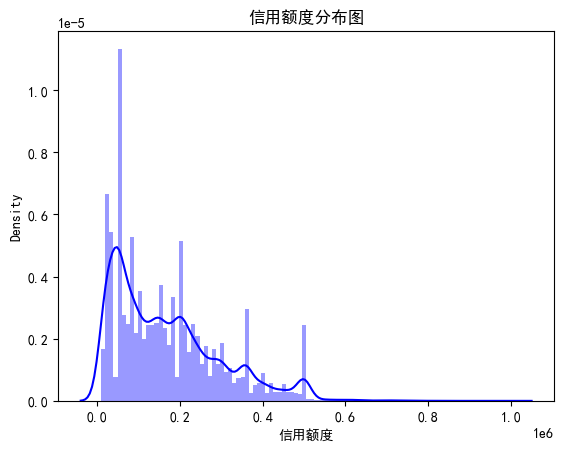

In [15]:
plt.title('信用额度分布图')
sns.set_color_codes("pastel")
sns.distplot(df['LIMIT_BAL'],kde=True,bins=100, color="blue")
plt.xlabel("信用额度")
plt.show()

可以看到信用额度的分布很不均匀，少数人群的信用额度非常高，大部分人的信用额度集中在较低的值。

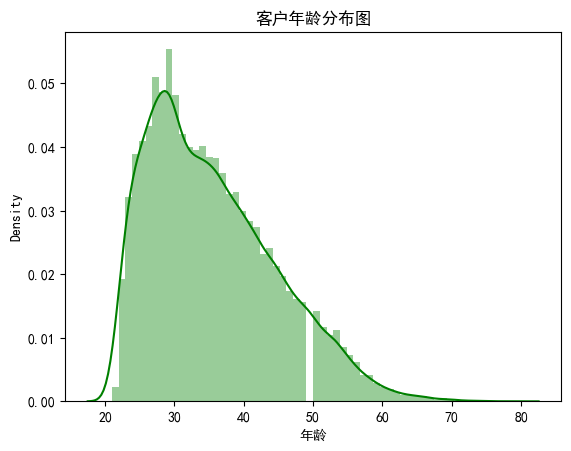

In [16]:
plt.title('客户年龄分布图')

sns.set_color_codes("pastel")
sns.distplot(df['AGE'],kde=True,bins=60, color="green")
plt.xlabel("年龄")
plt.show()

从图中能够发现，客户的年龄主要集中在20-40岁之间。

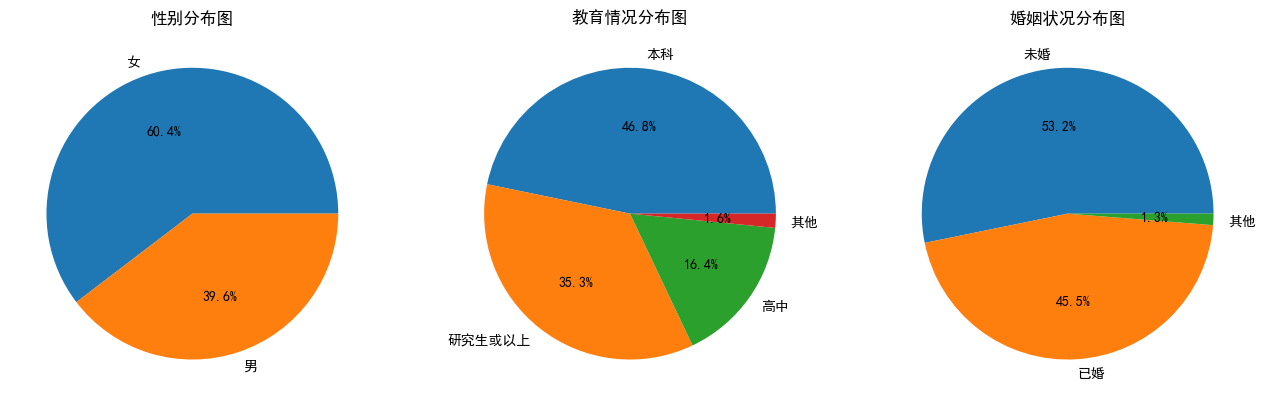

In [17]:
fig = plt.subplots(1,3,figsize=(16,12))

plt.subplot(1,3,1)
sex_count = df['SEX'].value_counts()
sex_count.plot(kind='pie', labels=['女', '男'], autopct='%1.1f%%')
plt.ylabel("")
plt.title('性别分布图')

plt.subplot(1,3,2)
edu_count = df['EDUCATION'].value_counts()
edu_count.plot(kind='pie', labels=['本科', '研究生或以上','高中','其他'], autopct='%1.1f%%')
plt.title('教育情况分布图')
plt.ylabel("")

plt.subplot(1,3,3)
mar_count = df['MARRIAGE'].value_counts()
mar_count.plot(kind='pie', labels=['未婚', '已婚','其他'], autopct='%1.1f%%')
plt.title('婚姻状况分布图')
plt.ylabel("")

plt.show()

从本图中可以看出性别的分布不均匀，女性占比显著高于男性。教育情况上，72%的客户教育程度都在本科或以上。婚姻状况则显示已婚和未婚客户的数目差距不多。

### 2.3.2 结合违约情况查看数据分布

得到了数据分布信息后，我们再结合对应的标签查看这些数据的特征，来考察对于不同的性别，年龄和教育情况，客户的违约情况是否有着比较显著的区别。

<Figure size 640x480 with 0 Axes>

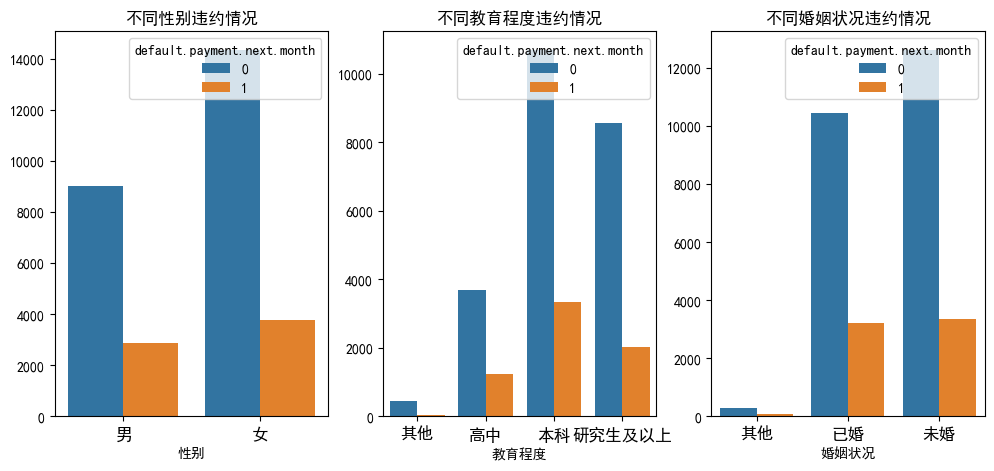

In [18]:
plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,5))

plt.subplot(1,3,1)
ax=sns.countplot(x='SEX',hue='default.payment.next.month',data = df)
ax.set_xticklabels(['男', '女'],fontsize=12)
plt.xlabel("性别")
plt.ylabel("")
plt.title('不同性别违约情况')

plt.subplot(1,3,2)
ax=sns.countplot(x='EDUCATION',hue='default.payment.next.month',data = df)
ax.set_xticklabels(['其他', '高中','本科','研究生及以上'],fontsize=12)
plt.xlabel("教育程度")
plt.ylabel("")
plt.title('不同教育程度违约情况')


plt.subplot(1,3,3)
ax=sns.countplot(x='MARRIAGE',hue='default.payment.next.month',data = df)
ax.set_xticklabels(['其他', '已婚','未婚'], fontsize=12)
plt.xlabel("婚姻状况")
plt.ylabel("")
plt.title('不同婚姻状况违约情况')

plt.show()

从图中可以看出，虽然男性的数量远低于女性，但违约人数并没有明显低于女性违约人数。对于婚姻状况也存在类似情况，未婚的人数比已婚人数多，但违约人数和已婚的违约人数相差无几，也说明了已婚人数的违约概率可能要大一些。我们再考察对于年龄和信用卡额度的违约情况。

<Figure size 640x480 with 0 Axes>

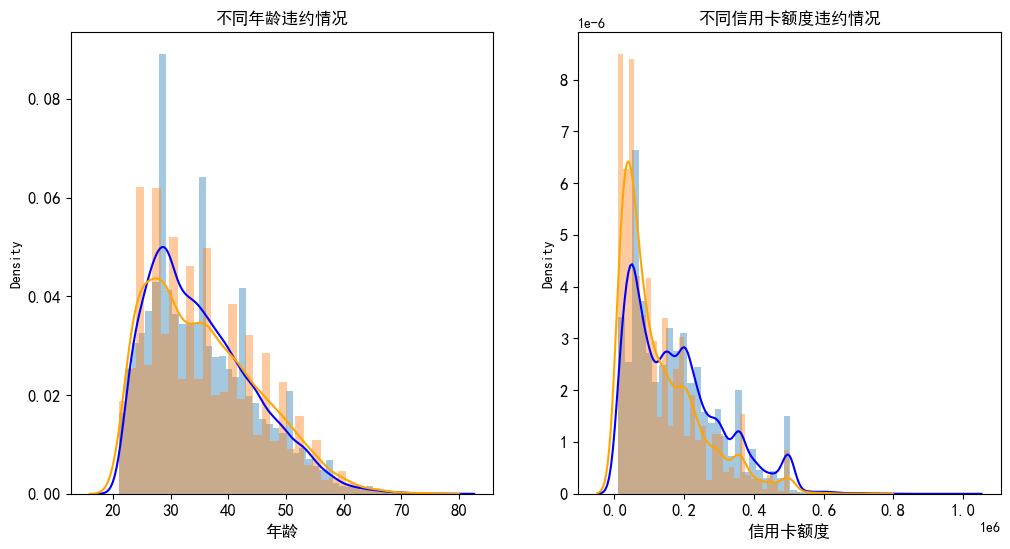

In [19]:
t0 = df[df['default.payment.next.month'] == 0]
t1 = df[df['default.payment.next.month'] == 1]
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(t0['AGE'],kde_kws={"color":"blue","label":"未违约"})
sns.distplot(t1['AGE'],kde_kws={"color":"orange","label":"违约"})
plt.xlabel('年龄', fontsize=12)
locs, labels = plt.xticks()
plt.title('不同年龄违约情况')
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(1,2,2)
sns.distplot(t0["LIMIT_BAL"],kde_kws={"color":"blue","label":"未违约"})
sns.distplot(t1["LIMIT_BAL"],kde_kws={"color":"orange","label":"违约"})
plt.xlabel('信用卡额度', fontsize=12)
locs, labels = plt.xticks()
plt.title('不同信用卡额度违约情况')
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

仔细观察上图，我们可以获取更多有趣的信息。例如30岁前，客户的违约概率更大；30-40岁之间是客户信用最高的区间，40岁之后再次下降；信用卡额度较低的客户违约概率更高。

### 2.3.3 展示数据相关性

为了观察变量间的相关性，我们也可以为连续型变量绘制一个热力图。

<Axes: title={'center': '连续型变量皮尔逊相关系数热力图'}>

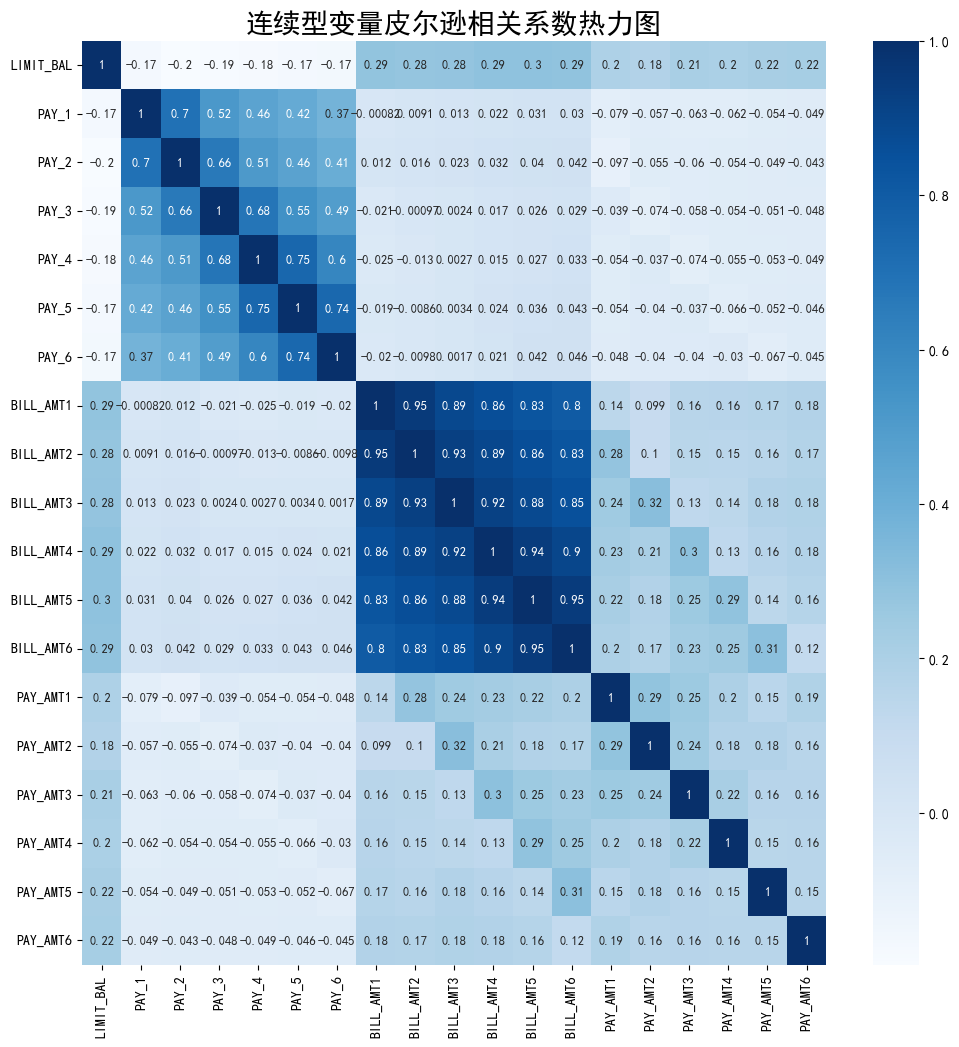

In [20]:
plt.figure(figsize = (12,12))
df1 = df.iloc[:,[1,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]].copy()
plt.title('连续型变量皮尔逊相关系数热力图',fontsize=20)
sns.heatmap(df1.corr(),annot = True,cmap="Blues",annot_kws={'fontsize':9})

可以看到每个用户不同月的消费记录之间具有强线性相关性，颜色十分深。还款记录也具有一定相关性，相对而言支付记录的相关性则比较低。还应该对离散型变量`SEX`,`EDUCATION`,`MARRIAGE`,`default.payment.next.month`进行检验。我们用Sklearn特征选择中的`chi2`输出离散特征的卡方统计量，并通过`score`和`pvalue`来评价这些特征和违约与否之间的相关性。

In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

y = df['default.payment.next.month']
X = df[['SEX','EDUCATION','MARRIAGE']]

chi2_selector = SelectKBest(chi2,k=2)
chi2_selector.fit(X,y)

SelectKBest(k=2, score_func=<function chi2 at 0x000002C6EF11F040>)

In [22]:
chi2_selector.scores_

array([18.9833263 ,  8.82571485,  4.88393907])

In [23]:
chi2_selector.pvalues_

array([1.31865748e-05, 2.97015018e-03, 2.71076893e-02])

`scores`越高，则说明特征和违约与否之间的相关性越强，反之则越弱；`pvalues`的值反之。
相对而言，性别的影响最大，婚姻情况的影响则最小。

# 3 分类建模

我们首先尝试使用一些基本的机器学习模型对数据直接进行分类建模，并给出分类的预测结果。我们选用比较经典的KNN和决策树来观察效果。

## 3.1 KNN模型

在KNN模型中，由于涉及到欧氏空间的距离概念，因此对于无序离散型变量，应该先对其做哑变量编码处理。我们对无序离散变量`SEX`,`MARRIAGE`进行哑变量编码。

In [24]:
str_columns = ['SEX','MARRIAGE']
df_new = pd.get_dummies(df, columns=str_columns)
df_new

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,SEX_0,SEX_1,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2
0,1,20000.0,2,24,2,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1,0,1,0,1,0
1,2,120000.0,2,26,0,2,0,0,0,2,...,1000.0,1000.0,0.0,2000.0,1,0,1,0,0,1
2,3,90000.0,2,34,0,0,0,0,0,0,...,1000.0,1000.0,1000.0,5000.0,0,0,1,0,0,1
3,4,50000.0,2,37,0,0,0,0,0,0,...,1200.0,1100.0,1069.0,1000.0,0,0,1,0,1,0
4,5,50000.0,2,57,0,0,0,0,0,0,...,10000.0,9000.0,689.0,679.0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,39,0,0,0,0,0,0,...,5003.0,3047.0,5000.0,1000.0,0,1,0,0,1,0
29996,29997,150000.0,1,43,0,0,0,0,0,0,...,8998.0,129.0,0.0,0.0,0,1,0,0,0,1
29997,29998,30000.0,2,37,4,3,2,0,0,0,...,22000.0,4200.0,2000.0,3100.0,1,1,0,0,0,1
29998,29999,80000.0,1,41,1,0,0,0,0,0,...,1178.0,1926.0,52964.0,1804.0,1,1,0,0,1,0


我们将数据集划分为标签列`y`和特征列`X`，为后面的处理做好准备。

In [25]:
y = df_new['default.payment.next.month']
X = df_new.drop(columns=['ID','default.payment.next.month'])

对于数值型的变量，不同变量定义的数值变化范围差的非常多，我们还应对这部分数据进行标准化处理。由于部分变量在总体中的最大最小值未知(例如客户的信用卡额度`LIMIT_BAL`)，因此我们选用ZScore标准化对特征列进行标准化处理，使得处理过后的每一列数据都是均值为0，标准差为1的数据。

In [26]:
X.iloc[:,0:20] = preprocessing.scale(X.iloc[:,0:20])
X.sample(5)

,LIMIT_BAL,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_0,SEX_1,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2
7460,2.562830,-0.211870,0.598248,-0.469071,-0.399186,-0.384614,-0.33999,-0.308621,-0.316688,1.634308,...,0.617732,0.840211,0.978235,0.997353,21.0,1,0,0,1,0
12266,0.944277,-1.555086,0.164303,-0.469071,-0.399186,-0.384614,-0.33999,-0.308621,-0.316688,-0.690264,...,-0.239802,-0.274310,-0.282785,-0.288217,396.0,0,1,0,0,1
4612,-1.136720,1.131346,-1.246020,-0.469071,-0.399186,-0.384614,-0.33999,-0.308621,-0.316688,-0.440042,...,-0.200567,-0.211606,-0.148480,-0.248683,1000.0,0,1,0,0,1
20913,-1.136720,-0.211870,-1.029047,0.845713,2.095469,2.145187,-0.33999,-0.308621,2.478850,-0.580533,...,-0.256990,-0.183208,-0.244230,-0.314136,1200.0,1,0,0,0,1
14301,-0.905498,-1.555086,2.442516,-0.469071,-0.399186,-0.384614,-0.33999,-0.308621,-0.316688,-0.068233,...,-0.201045,-0.251989,-0.265997,-0.268711,623.0,1,0,1,0,0


我们选取某一列数据，打印出它的均值和标准差，验证ZScore标准化的效果。

In [27]:
print ('均值为：{a}'.format(a = X.LIMIT_BAL.mean()))
print ('标准差为：{a}'.format(a = X.LIMIT_BAL.std()))

均值为：-6.063298011819522e-17
标准差为：1.0000166670832442


可以看到均值逼近0，标准差逼近1，说明标准化成功，接下来我们对数据进行训练集和测试集的划分。选取测试集大小为0.3，`random_state`参数指伪随机数的状态参数)。

In [28]:
X_train, X_test,\
y_train, y_test \
= train_test_split(X, y, test_size=0.3, random_state=0)

划分训练集测试集后，打印出标签为1和0的值在训练集和测试集中的占比，测试划分效果。

In [29]:
print (y_train.value_counts()/len(y_train))
print (y_test.value_counts()/len(y_test))

0    0.776381
1    0.223619
Name: default.payment.next.month, dtype: float64
0    0.784444
1    0.215556
Name: default.payment.next.month, dtype: float64


下面，我们使用sklearn中的`KNeighborsClassifier`对训练集进行分类训练。当不输入参数时，默认KNN所选取的`n_neighbors`参数取值为5。

In [32]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

得到模型`knn_model`后，我们在测试集上验证其分类效果，用`predict`方法获取模型对每一个测试集样本标签的预测结果`knn_pred`。用`predict_proba`方法获取模型把每一个样本划分为正类的概率`knn_score`。

In [34]:
# 将X_test转换为C连续的数组
X_test_contiguous = np.ascontiguousarray(X_test)

# 然后再进行预测
knn_score = knn_model.predict_proba(X_test_contiguous)[:,1]
knn_pred = knn_model.predict(X_test_contiguous)

Exception in thread Thread-6:
Traceback (most recent call last):
  File "d:\anaconda\envs\dd\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "d:\anaconda\envs\dd\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "d:\anaconda\envs\dd\lib\subprocess.py", line 1495, in _readerthread
    buffer.append(fh.read())
  File "d:\anaconda\envs\dd\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 24: invalid start byte
  File "d:\anaconda\envs\dd\lib\site-packages\joblib\externals\loky\backend\context.py", line 262, in _count_physical_cores
    cpu_info = cpu_info.stdout.splitlines()


为了展示分类模型的效果，我们需要获取模型的AUC得分(`accuracy_score`)，分类报告以及混淆矩阵。为了方便后续使用，我们定义一个函数`Get_report`来获取这些信息。

In [35]:
def Get_report(testers , predictors):
    print ('模型的AUC Score为：{a}'.format(a=metrics.accuracy_score(testers, predictors)))
    print ('模型的分类报告展示如下:')
    print (metrics.classification_report(testers, predictors))
    print ('模型的混淆矩阵展示如下:')
    plt.figure(figsize=(8,4))
    ConfMatrix = confusion_matrix(testers, predictors)
    sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['未违约', '违约'], 
            yticklabels = ['未违约', '违约'])
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.title("混淆矩阵")

我们向这个函数中传入之前得到的`y_test`和`knn_pred`,展示KNN模型的分类效果报告。

模型的AUC Score为：0.7912222222222223
模型的分类报告展示如下:
              precision    recall  f1-score   support

           0       0.82      0.93      0.88      7060
           1       0.53      0.27      0.36      1940

    accuracy                           0.79      9000
   macro avg       0.68      0.60      0.62      9000
weighted avg       0.76      0.79      0.76      9000

模型的混淆矩阵展示如下:


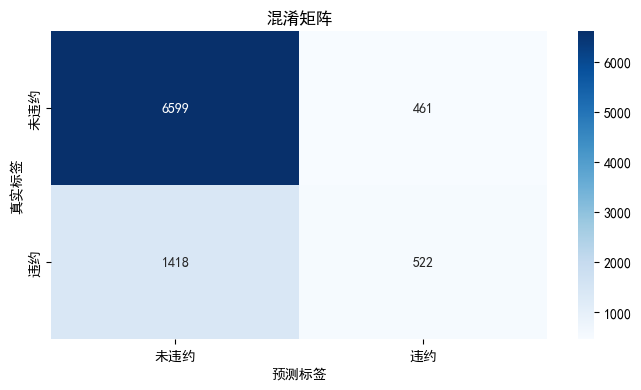

In [36]:
Get_report(y_test , knn_pred)

我们发现，虽然总体预测的精准度尚可，违约样本的实际召回率只有0.27，能够综合展示正类样本的准确率和召回率的`f1-score`只有0.36。我们再尝试其他模型进行对比。

## 3.2 决策树

我们再引入决策树算法，直接进行模型训练，并展示模型训练结果，与KNN得到的结果进行对比。

In [37]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(random_state=1)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

模型的AUC Score为：0.7285555555555555
模型的分类报告展示如下:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      7060
           1       0.38      0.42      0.40      1940

    accuracy                           0.73      9000
   macro avg       0.61      0.62      0.61      9000
weighted avg       0.74      0.73      0.73      9000

模型的混淆矩阵展示如下:


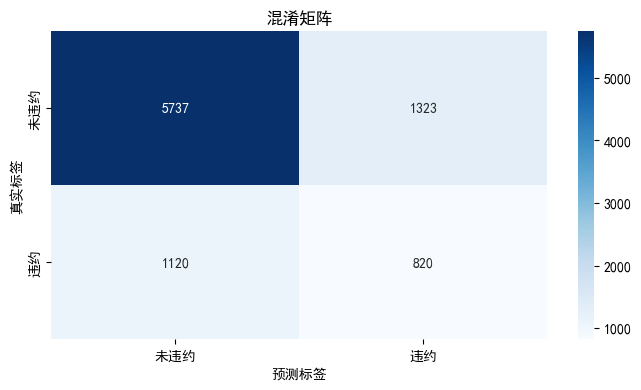

In [38]:
tree_score = tree_model.predict_proba(X_test)[:,1]
tree_pred = tree_model.predict(X_test)
Get_report(y_test,tree_pred)

可以看到，决策树相比KNN，在召回率和`f1-score`上有所提升，但还是不能令人满意。

# 5 XGBoost

下面我们引入一种强力的算法-XGBoost，作为Boosting的代表之一，它是对GBDT(Gradient Boosting Decision Tree)的一种改进，我们在对数据进行重采样后进行学习。

In [41]:
from xgboost import XGBClassifier
model = XGBClassifier(booster='gbtree',learning_rate=0.1,gamma=1,scale_pos_weight=1,n_estimators=1000,max_depth=6,alpha=5,reg_lambda=1)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set, verbose=False)


XGBClassifier(alpha=5, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

`learning_rate`参数代表学习率，决定着目标函数能否收敛到局部最小值以及何时收敛到最小值。`alpha`和`reg_lambda`分别对应L1，L2正则项系数。

模型的AUC Score为：0.8248888888888889
模型的分类报告展示如下:
              precision    recall  f1-score   support

           0       0.84      0.95      0.90      7060
           1       0.68      0.35      0.47      1940

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.68      9000
weighted avg       0.81      0.82      0.80      9000

模型的混淆矩阵展示如下:


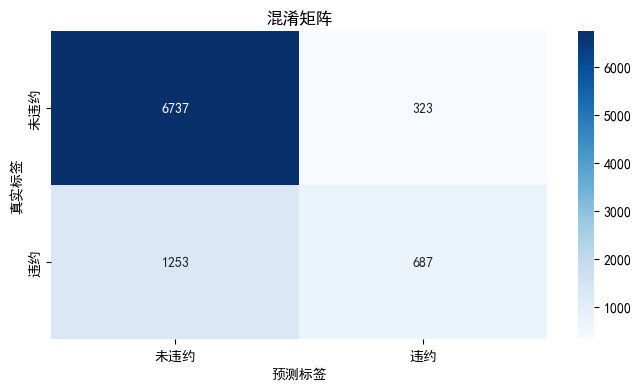

In [42]:
y_pred = model.predict(X_test)
y_socre = model.predict_proba(X_test)[:,1]
predictions = [round(value) for value in y_pred]
Get_report(y_test,y_pred)

# 6 结论

   本案例最终得到的分类效果差强人意，最好的AUC值为0.8左右，正类样本得到的最高`F1`值为0.55，对于信用卡违约这样一个对正类样本召回率要求较高的场景，往往需要更高的召回率和准确率。然而受数据限制，本数据集较难在最终的结果上实现很好的分类效果，但对于不同算法和指标的处理和参考是值得复习的。